In [ ]:
!pip install datasets
!pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.2 MB/s eta 0:00:00
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-ex2kc1w6
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-ex2kc1w6
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9604f5995cc628619f0e4fd913453b4d7d61db3f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.8 MB/s eta 0:00:00
  Preparing metad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 81.9 MB/s eta 0:00:00


In [ ]:
!pip install pdf2image

In [ ]:
import numpy as np
from transformers import LayoutLMv2Processor, LayoutLMv2Tokenizer, LayoutLMv2ForTokenClassification, AdamW
from datasets import load_dataset, Dataset, Features, Sequence, ClassLabel, Value, Array2D, Array3D
import torch
from PIL import Image, ImageDraw, ImageFont

In [ ]:
funsd_dataset = load_dataset("nielsr/funsd")

id2label = ["O", "B-HEADER", "I-HEADER", "B-QUESTION", "I-QUESTION", "B-ANSWER", "I-ANSWER"]
label2id = {l:i for i, l in enumerate(id2label)}
label2id

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


funsd.py:   0%|          | 0.00/4.54k [00:00<?, ?B/s]

The repository for nielsr/funsd contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/nielsr/funsd.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

{'O': 0,
 'B-HEADER': 1,
 'I-HEADER': 2,
 'B-QUESTION': 3,
 'I-QUESTION': 4,
 'B-ANSWER': 5,
 'I-ANSWER': 6}

In [ ]:
type(funsd_dataset)

datasets.dataset_dict.DatasetDict

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = LayoutLMv2Processor.from_pretrained(
    "microsoft/layoutlmv2-base-uncased", revision="no_ocr"
)
model = LayoutLMv2ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv2-base-uncased", num_labels=len(id2label)
)

model.to(device);

preprocessor_config.json:   0%|          | 0.00/135 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/802M [00:00<?, ?B/s]

Some weights of LayoutLMv2ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for i in range(5):
  Image.open(funsd_dataset['train']['image_path'][i]).convert('RGB').save(f'image_{i}.png')

In [ ]:
def encode_training_example(examples):
    images = [Image.open(path).convert("RGB") for path in examples['image_path']]
    words = examples['words']
    boxes = examples['bboxes']
    word_labels = examples['ner_tags']

    encoded_inputs = processor(
        images, words, boxes=boxes, word_labels=word_labels, padding="max_length", truncation=True
    )

    return encoded_inputs

training_features = Features({
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(ClassLabel(names=id2label)),
})

def training_dataloader_from_dataset(dataset):
    encoded_data = dataset.map(
        encode_training_example, batched=True, remove_columns=funsd_dataset['train'].column_names,
        features=training_features
    )
    encoded_data.set_format(type='torch', device=device)
    dataloader = torch.utils.data.DataLoader(encoded_data, batch_size=4, shuffle=True)
    batch = next(iter(dataloader))

    return dataloader
train_dataloader = training_dataloader_from_dataset(funsd_dataset['train'])
valid_dataloader = training_dataloader_from_dataset(funsd_dataset['test'])

Map:   0%|          | 0/149 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [ ]:
funsd_dataset['train'].column_names

['id', 'words', 'bboxes', 'ner_tags', 'image_path']

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 5


for epoch in range(num_epochs):
    print("Epoch:", epoch)
    training_loss = 0.0
    model.train()
    for batch in tqdm(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss

        training_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print("Training Loss:", training_loss / batch["input_ids"].shape[0])

    validation_loss = 0.0
    for batch in tqdm(valid_dataloader):
        outputs = model(**batch)
        loss = outputs.loss

        validation_loss += loss.item()

    print("Validation Loss:", validation_loss / batch["input_ids"].shape[0])

[{'token': '1', 'label': 'DATE', 'bbox': [{'x': 1454, 'y': 405}, {'x': 1468, 'y': 405}, {'x': 1468, 'y': 408}, {'x': 1454, 'y': 408}]}, {'token': 'day', 'label': 'DATE', 'bbox': [{'x': 1501, 'y': 380}, {'x': 1560, 'y': 380}, {'x': 1560, 'y': 406}, {'x': 1501, 'y': 406}]}, {'token': 'of', 'label': 'DATE', 'bbox': [{'x': 1566, 'y': 378}, {'x': 1602, 'y': 378}, {'x': 1602, 'y': 404}, {'x': 1566, 'y': 404}]}, {'token': '20', 'label': 'DATE', 'bbox': [{'x': 433, 'y': 425}, {'x': 473, 'y': 425}, {'x': 473, 'y': 457}, {'x': 433, 'y': 457}]}, {'token': ',', 'label': 'DATE', 'bbox': [{'x': 495, 'y': 425}, {'x': 507, 'y': 425}, {'x': 507, 'y': 457}, {'x': 495, 'y': 457}]}]


In [ ]:
model.save_pretrained('saved_model/')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LayoutLMv2ForTokenClassification.from_pretrained("saved_model")
model.to(device);
labels = ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']
id2label = {v: k for v, k in enumerate(labels)}
label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}
query_index = 0
query = funsd_dataset['test'][query_index]
image = Image.open(query['image_path'])
image = image.convert("RGB")
image

In [ ]:
encoded_inputs = processor(
    image, query['words'], boxes=query['bboxes'], word_labels=query['ner_tags'],
    padding="max_length", truncation=True, return_tensors="pt"
).to(device)
outputs = model(**encoded_inputs)
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoded_inputs.bbox.squeeze().tolist()

width, height = image.size

true_predictions = [id2label[prediction] for prediction in predictions]
true_boxes = [unnormalize_box(box, width, height) for box in token_boxes]
draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
        return 'other'
    return label

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text(
        (box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label], font=font
    )

image

# PII for 40 images

In [7]:
!pip install transformers torch torchvision pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [8]:
DRIVE_LINK = r"/content/drive/MyDrive/omdena_legal"

In [9]:
!pip install pytesseract

In [10]:
!sudo apt-get install libleptonica-dev tesseract-ocr libtesseract-dev libtesseract-dev python3-pil tesseract-ocr-eng tesseract-ocr-script-latn

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libarchive-dev libimagequant0 libraqm0 python3-olefile tesseract-ocr-osd
Suggested packages:
  python-pil-doc
The following NEW packages will be installed:
  libarchive-dev libimagequant0 libleptonica-dev libraqm0 libtesseract-dev
  python3-olefile python3-pil tesseract-ocr tesseract-ocr-eng
  tesseract-ocr-osd tesseract-ocr-script-latn
0 upgraded, 11 newly installed, 0 to remove and 20 not upgraded.
Need to get 39.9 MB of archives.
After this operation, 123 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libarchive-dev amd64 3.6.0-1ubuntu1.3 [581 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libimagequant0 amd64 2.17.0-1 [34.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libleptonica-dev amd64 1.82.0-3build1 [1,562 kB]
Get:4 http://archive.ubuntu

# PII dataset for all files

In [11]:
import os
import json
from PIL import Image
import pytesseract
from pytesseract import Output

# Function to extract text and bounding boxes using Tesseract OCR
def extract_text_and_boxes(image_path):
    # Load the image
    image = Image.open(image_path)
    # Use Tesseract to extract text and bounding boxes
    ocr_data = pytesseract.image_to_data(image, output_type=Output.DICT)
    # Extract words and their bounding boxes
    words = []
    boxes = []
    for i in range(len(ocr_data['text'])):
        if ocr_data['text'][i].strip():  # Only consider non-empty words
            words.append(ocr_data['text'][i])
            x = ocr_data['left'][i]
            y = ocr_data['top'][i]
            w = ocr_data['width'][i]
            h = ocr_data['height'][i]
            boxes.append([x, y, x + w, y + h])  # Convert to [x1, y1, x2, y2] format
    return words, boxes

# Function to check if two bounding boxes overlap
def do_boxes_overlap(box1, box2):
    """
    Check if two bounding boxes overlap.
    Each box is represented as [x_min, y_min, x_max, y_max].
    """
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2
    return not (x1_max < x2_min or x2_max < x1_min or y1_max < y2_min or y2_max < y1_min)

# Define paths
input_images_dir = '/content/drive/MyDrive/omdena_legal/images_less'  # Directory containing your images
input_annotations_dir = '/content/drive/MyDrive/omdena_legal/annotation_legal_less'  # Directory containing your annotation JSON files
output_data_dir = 'data2'  # Output directory for FUNSD-formatted data

# Create output directory if it doesn't exist
os.makedirs(output_data_dir, exist_ok=True)

# Initialize FUNSD-compatible data structure
funsd_data = []
ner_dict = {"O":0, "PII":1}
# Iterate over all images in the input directory
for image_name in os.listdir(input_images_dir):
    # Construct full path to the image
    image_path = os.path.join(input_images_dir, image_name)

    # Construct the corresponding annotation file name
    annotation_file_name = f"LegalRedaction Document (lesser resolution)_dataset 2025-02-16 07-20-26_{image_name}.json"
    annotation_path = os.path.join(input_annotations_dir, annotation_file_name)

    # Skip if the annotation file does not exist
    if not os.path.exists(annotation_path):
        print(f"Annotation file not found for {image_name}. Skipping...")
        continue

    # Load the annotation file
    with open(annotation_path, 'r') as f:
        annotations = json.load(f)

    # Extract the annotation data
    annotation_data = annotations["annotation"]

    # Extract image metadata
    image_base_name = os.path.splitext(image_name)[0]
    output_image_path = os.path.join(output_data_dir, f"{image_base_name}.png")

    # Load the image
    image = Image.open(image_path)

    # Convert and save the image in PNG format
    image.save(output_image_path, format='PNG')

    # Extract words and bounding boxes using OCR
    words, ocr_bboxes = extract_text_and_boxes(image_path)

    # Prepare FUNSD-compatible fields
    ner_tags = []

    # Iterate over each word and its bounding box from OCR
    for word, ocr_bbox in zip(words, ocr_bboxes):
        # Default NER tag is "O" (outside any annotation)
        ner_tag = "O"

        # Check if the OCR bounding box overlaps with any annotated bounding box
        for obj in annotation_data["objects"]:
            exterior_points = obj["points"]["exterior"]
            x_min, y_min = exterior_points[0]
            x_max, y_max = exterior_points[1]
            annotation_bbox = [x_min, y_min, x_max, y_max]

            if do_boxes_overlap(ocr_bbox, annotation_bbox):
                # Assign the NER tag from the annotation
                ner_tag = obj["classTitle"]
                break  # Stop checking once a match is found

        # Append the NER tag
        # ner_tags.append(ner_tag)
        ner_tags.append(ner_dict[ner_tag])

    # Create FUNSD-compatible entry
    funsd_entry = {
        "id": image_base_name,
        "words": words,
        "bboxes": ocr_bboxes,
        "ner_tags": ner_tags,
        "image_path": output_image_path
    }

    # Add the entry to the FUNSD data
    funsd_data.append(funsd_entry)

# Save the FUNSD data as a JSON file
output_data_file = os.path.join(output_data_dir, "funsd_data.json")
with open(output_data_file, 'w') as f:
    json.dump(funsd_data, f, indent=4)

print("Conversion completed successfully!")

Conversion completed successfully!


In [12]:
import json
from datasets import Dataset, DatasetDict

# Define paths
input_json_file = '/content/data2/funsd_data.json'  # Path to your FUNSD-formatted JSON file

# Load the JSON data
with open(input_json_file, 'r') as f:
    funsd_data = json.load(f)

# Prepare data for the dataset
data = {
    "id": [],
    "words": [],
    "bboxes": [],
    "ner_tags": [],
    "image_path": []
}

for entry in funsd_data:
    data["id"].append(entry["id"])
    data["words"].append(entry["words"])
    data["bboxes"].append(entry["bboxes"])
    data["ner_tags"].append(entry["ner_tags"])
    data["image_path"].append(entry["image_path"])

# Create a Hugging Face Dataset
dataset = Dataset.from_dict(data)

# Split the dataset into train and test (e.g., 80% train, 20% test)
train_test_split = dataset.train_test_split(test_size=0.1)

# Create a DatasetDict
dataset_dict = DatasetDict({
    "train": train_test_split["train"],
    "test": train_test_split["test"]
})

# Print the DatasetDict structure
print(dataset_dict)

# Optionally, save the DatasetDict to disk
output_dir = "/content/dataset_dict"
dataset_dict.save_to_disk(output_dir)

print("DatasetDict created and saved successfully!")

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 10
    })
    test: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 2
    })
})


Saving the dataset (0/1 shards):   0%|          | 0/10 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2 [00:00<?, ? examples/s]

DatasetDict created and saved successfully!


In [13]:
id2label = ["O", "PII"]
label2id = {l:i for i, l in enumerate(id2label)}
label2id

{'O': 0, 'PII': 1}

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = LayoutLMv2Processor.from_pretrained(
    "microsoft/layoutlmv2-base-uncased", revision="no_ocr"
)
model = LayoutLMv2ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv2-base-uncased", num_labels=len(id2label)
)

model.to(device);

Some weights of LayoutLMv2ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
def encode_training_example(examples):
    images = [Image.open(path).convert("RGB") for path in examples['image_path']]
    words = examples['words']
    boxes = examples['bboxes']
    word_labels = examples['ner_tags']

    encoded_inputs = processor(
        images, words, boxes=boxes, word_labels=word_labels, padding="max_length", truncation=True
    )

    return encoded_inputs

training_features = Features({
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(ClassLabel(names=id2label)),
})

def training_dataloader_from_dataset(dataset):
    encoded_data = dataset.map(
        encode_training_example, batched=True, remove_columns=dataset_dict['train'].column_names,
        features=training_features
    )
    encoded_data.set_format(type='torch', device=device)
    dataloader = torch.utils.data.DataLoader(encoded_data, batch_size=2, shuffle=True)
    batch = next(iter(dataloader))

    return dataloader
train_dataloader = training_dataloader_from_dataset(dataset_dict['train'])
valid_dataloader = training_dataloader_from_dataset(dataset_dict['test'])

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

In [16]:
from tqdm import tqdm
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 5


for epoch in range(num_epochs):
    print("Epoch:", epoch)
    training_loss = 0.0
    model.train()
    for batch in tqdm(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss

        training_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print("Training Loss:", training_loss / batch["input_ids"].shape[0])

    validation_loss = 0.0
    for batch in tqdm(valid_dataloader):
        outputs = model(**batch)
        loss = outputs.loss

        validation_loss += loss.item()

    print("Validation Loss:", validation_loss / batch["input_ids"].shape[0])

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch: 0


100%|██████████| 5/5 [02:02<00:00, 24.54s/it]


Training Loss: 1.5075284242630005


100%|██████████| 1/1 [00:07<00:00,  7.48s/it]


Validation Loss: 0.21563637256622314
Epoch: 1


100%|██████████| 5/5 [01:49<00:00, 21.91s/it]


Training Loss: 1.1351579874753952


100%|██████████| 1/1 [00:06<00:00,  6.28s/it]


Validation Loss: 0.17763739824295044
Epoch: 2


100%|██████████| 5/5 [01:53<00:00, 22.64s/it]


Training Loss: 0.822927862405777


100%|██████████| 1/1 [00:07<00:00,  7.37s/it]


Validation Loss: 0.1445113718509674
Epoch: 3


100%|██████████| 5/5 [01:43<00:00, 20.70s/it]


Training Loss: 0.6109555959701538


100%|██████████| 1/1 [00:06<00:00,  6.24s/it]


Validation Loss: 0.11863479763269424
Epoch: 4


100%|██████████| 5/5 [01:41<00:00, 20.37s/it]


Training Loss: 0.48323433846235275


100%|██████████| 1/1 [00:07<00:00,  7.78s/it]

Validation Loss: 0.0999128594994545


In [17]:
model1 = model

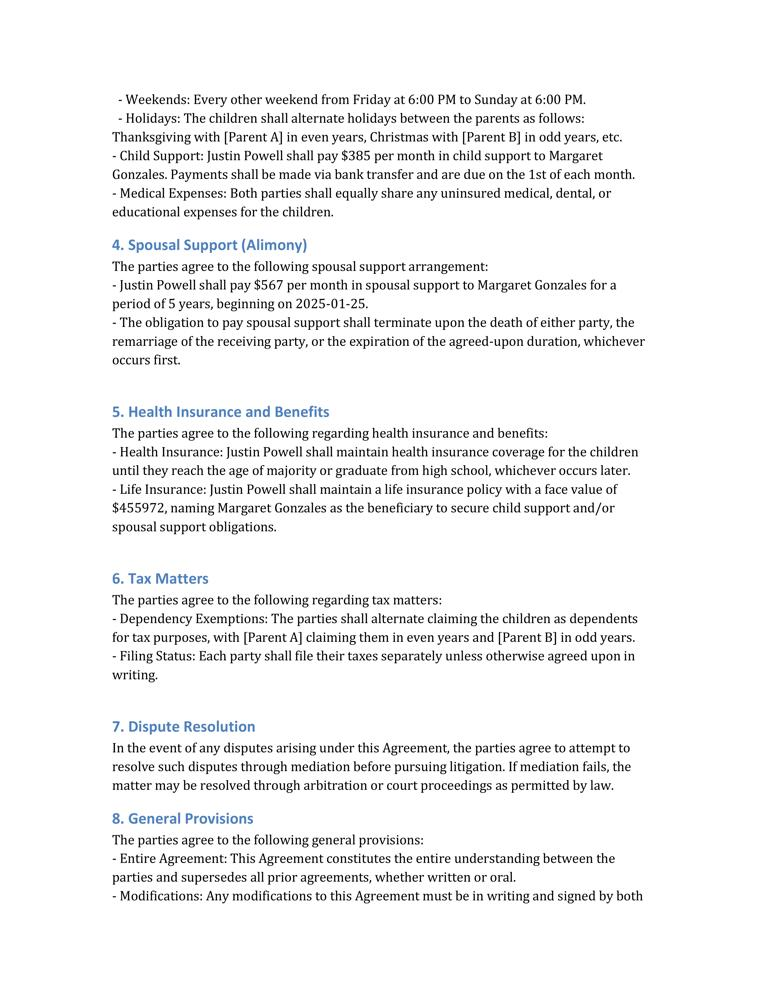

In [20]:
model.save_pretrained('saved_model/')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LayoutLMv2ForTokenClassification.from_pretrained("saved_model")
model.to(device);
labels = ["O", "PII"]
id2label = {l:i for i, l in enumerate(id2label)}
label2color = {'PII':'blue', 'O':'orange'}
query_index = 0
query = dataset_dict['test'][query_index]
image = Image.open(query['image_path'])
image = image.convert("RGB")
image

In [24]:
id2label = {0:'O',1:'PII'}

In [25]:
encoded_inputs = processor(
    image, query['words'], boxes=query['bboxes'], word_labels=query['ner_tags'],
    padding="max_length", truncation=True, return_tensors="pt"
).to(device)
outputs = model(**encoded_inputs)
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoded_inputs.bbox.squeeze().tolist()

width, height = image.size

true_predictions = [id2label[prediction] for prediction in predictions]
true_boxes = [unnormalize_box(box, width, height) for box in token_boxes]
draw = ImageDraw.Draw(image)

font = ImageFont.load_default()



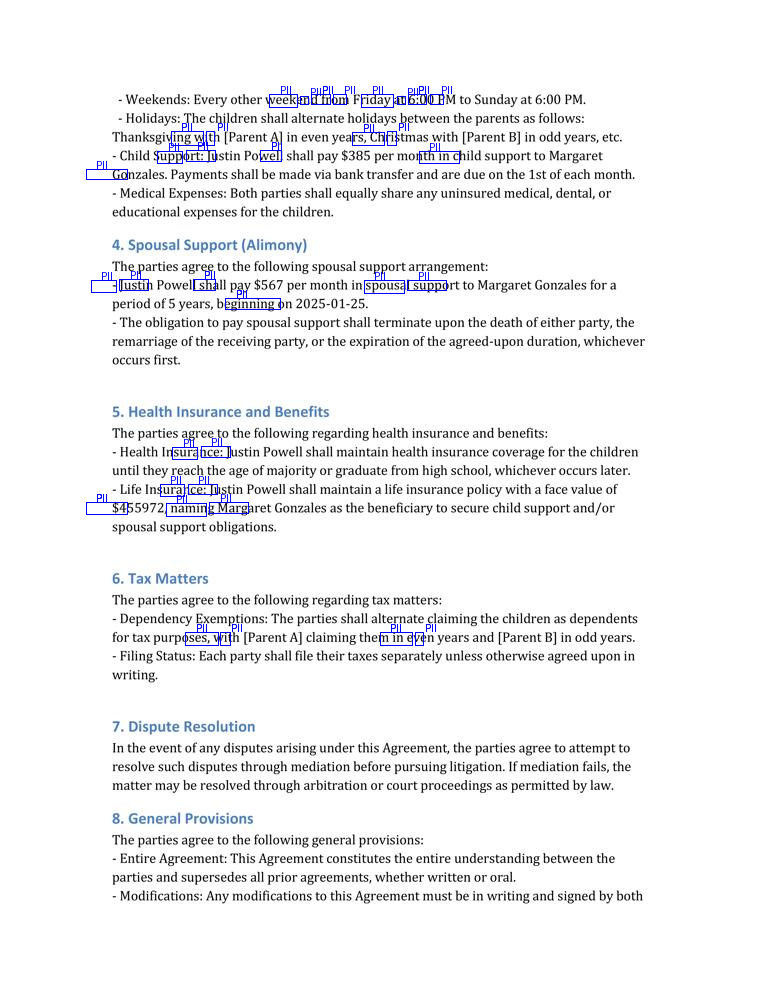

In [27]:
def iob_to_label(label):
    if not label:
        return 'other'
    return label

label2color = {'PII':'blue', 'O':'orange'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction)
    if(predicted_label == 'PII'):
      draw.rectangle(box, outline=label2color[predicted_label])
      draw.text(
          (box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label], font=font
      )
    else:
      pass
image